In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

TEMP_LOW_LIMIT = -459.67
TEMP_HIGH_LIMIT = 1000
RPM_LOW_LIMIT = 0
RPM_HIGH_LIMIT = 6e8  # the largest achieved rpm of all human artifacts

In [5]:
def exclude_physical_anml(df):
    result = df[(df['motor_temp'] > TEMP_LOW_LIMIT) & (df['inlet_temp'] > TEMP_LOW_LIMIT) & (df['rpm'] > 0) & (df['rpm'] < RPM_HIGH_LIMIT)]
    return result

def peek_attributes_trend(attribute, ylim_low=-10, ylim_high=1500):
    units = ["000{}".format(num) if num < 10 else "00{}".format(num) for num in random.sample(range(0, 20), 9)]
    file_names = ["../data/raw/train/unit{}_rms.csv".format(unit) for unit in units]
    sns.set()
    f, axs = plt.subplots(3, 3, figsize=(20, 12))
    for idx, file_name in enumerate(file_names):
        file_df = pd.read_csv(file_name)
        file_df = exclude_physical_anml(file_df)
        ax1 = plt.subplot(3, 3, idx + 1)
        file_df[attribute].plot(ylim=(ylim_low, ylim_high))
    plt.show()

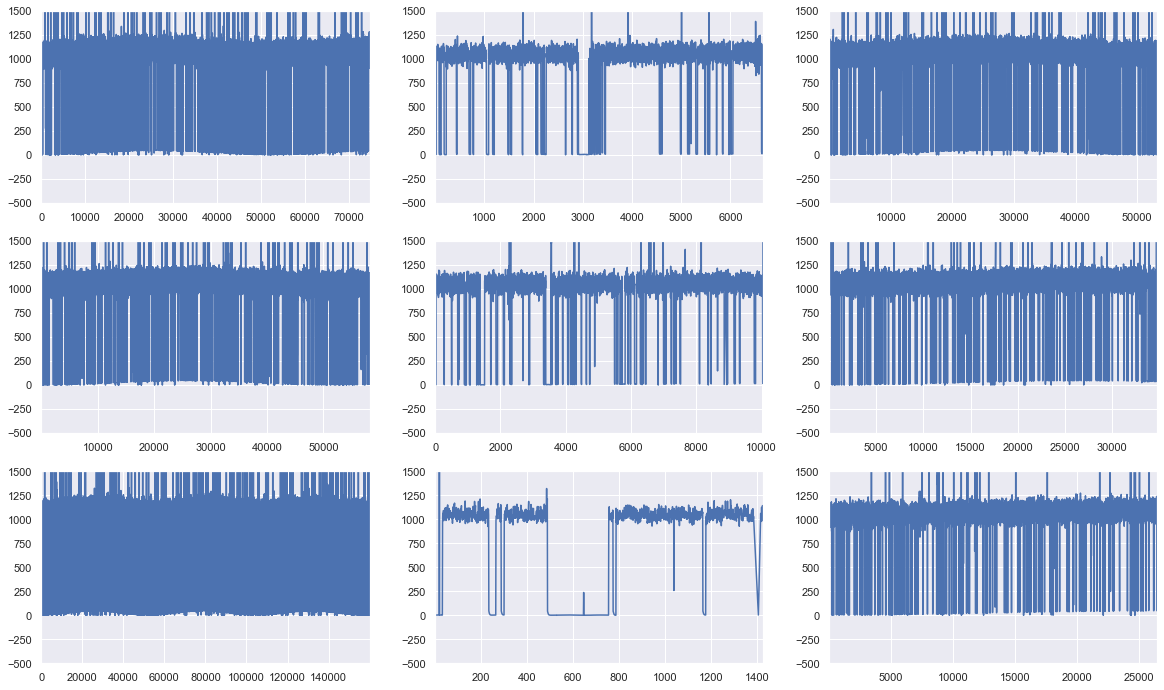

In [9]:
peek_attributes_trend('rpm', ylim_low=-500, ylim_high=1500)

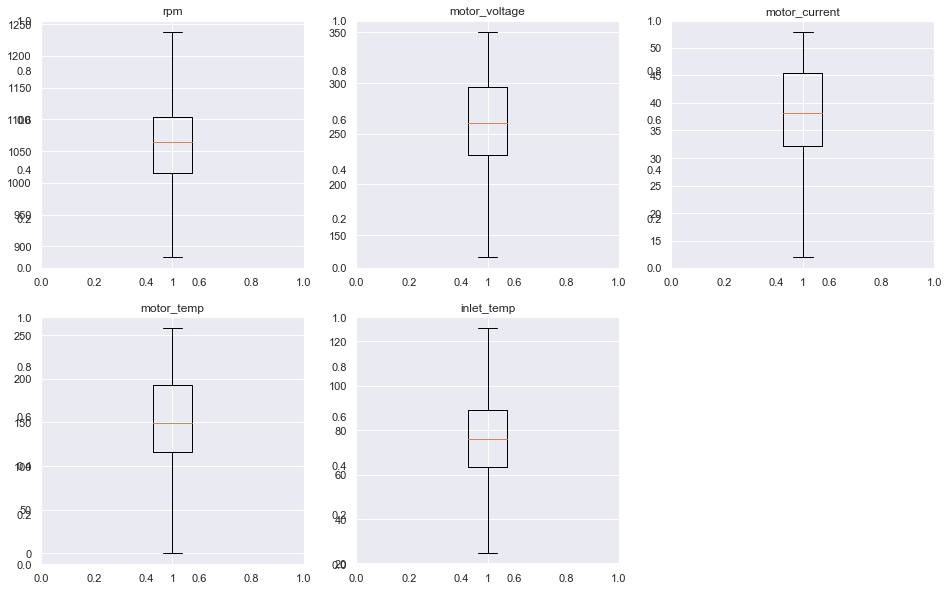

In [29]:
df = pd.read_csv("../data/raw/train/unit0001_rms.csv")
df = exclude_physical_anml(df)
feature_names = df.columns[1:].tolist()
fig, axs = plt.subplots(2, 3, figsize=(16, 10))
axs[1][2].set_visible(False)
for idx, feature in enumerate(feature_names):
    ax = fig.add_subplot(2, 3, idx + 1)
    ax.boxplot(df[feature], 0, '')
    ax.title.set_text(feature)